In [84]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse

W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e2_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv = w51conv + 'w51n_B6_conv.fits'
w51n_b3_conv = w51conv + 'w51n_B3_conv.fits'
w51e_b3_conv = w51conv + 'w51e_B3_conv.fits'
w51e_b6_conv = w51conv + 'w51e_B6_conv.fits'







(5000.0, 7000.0)

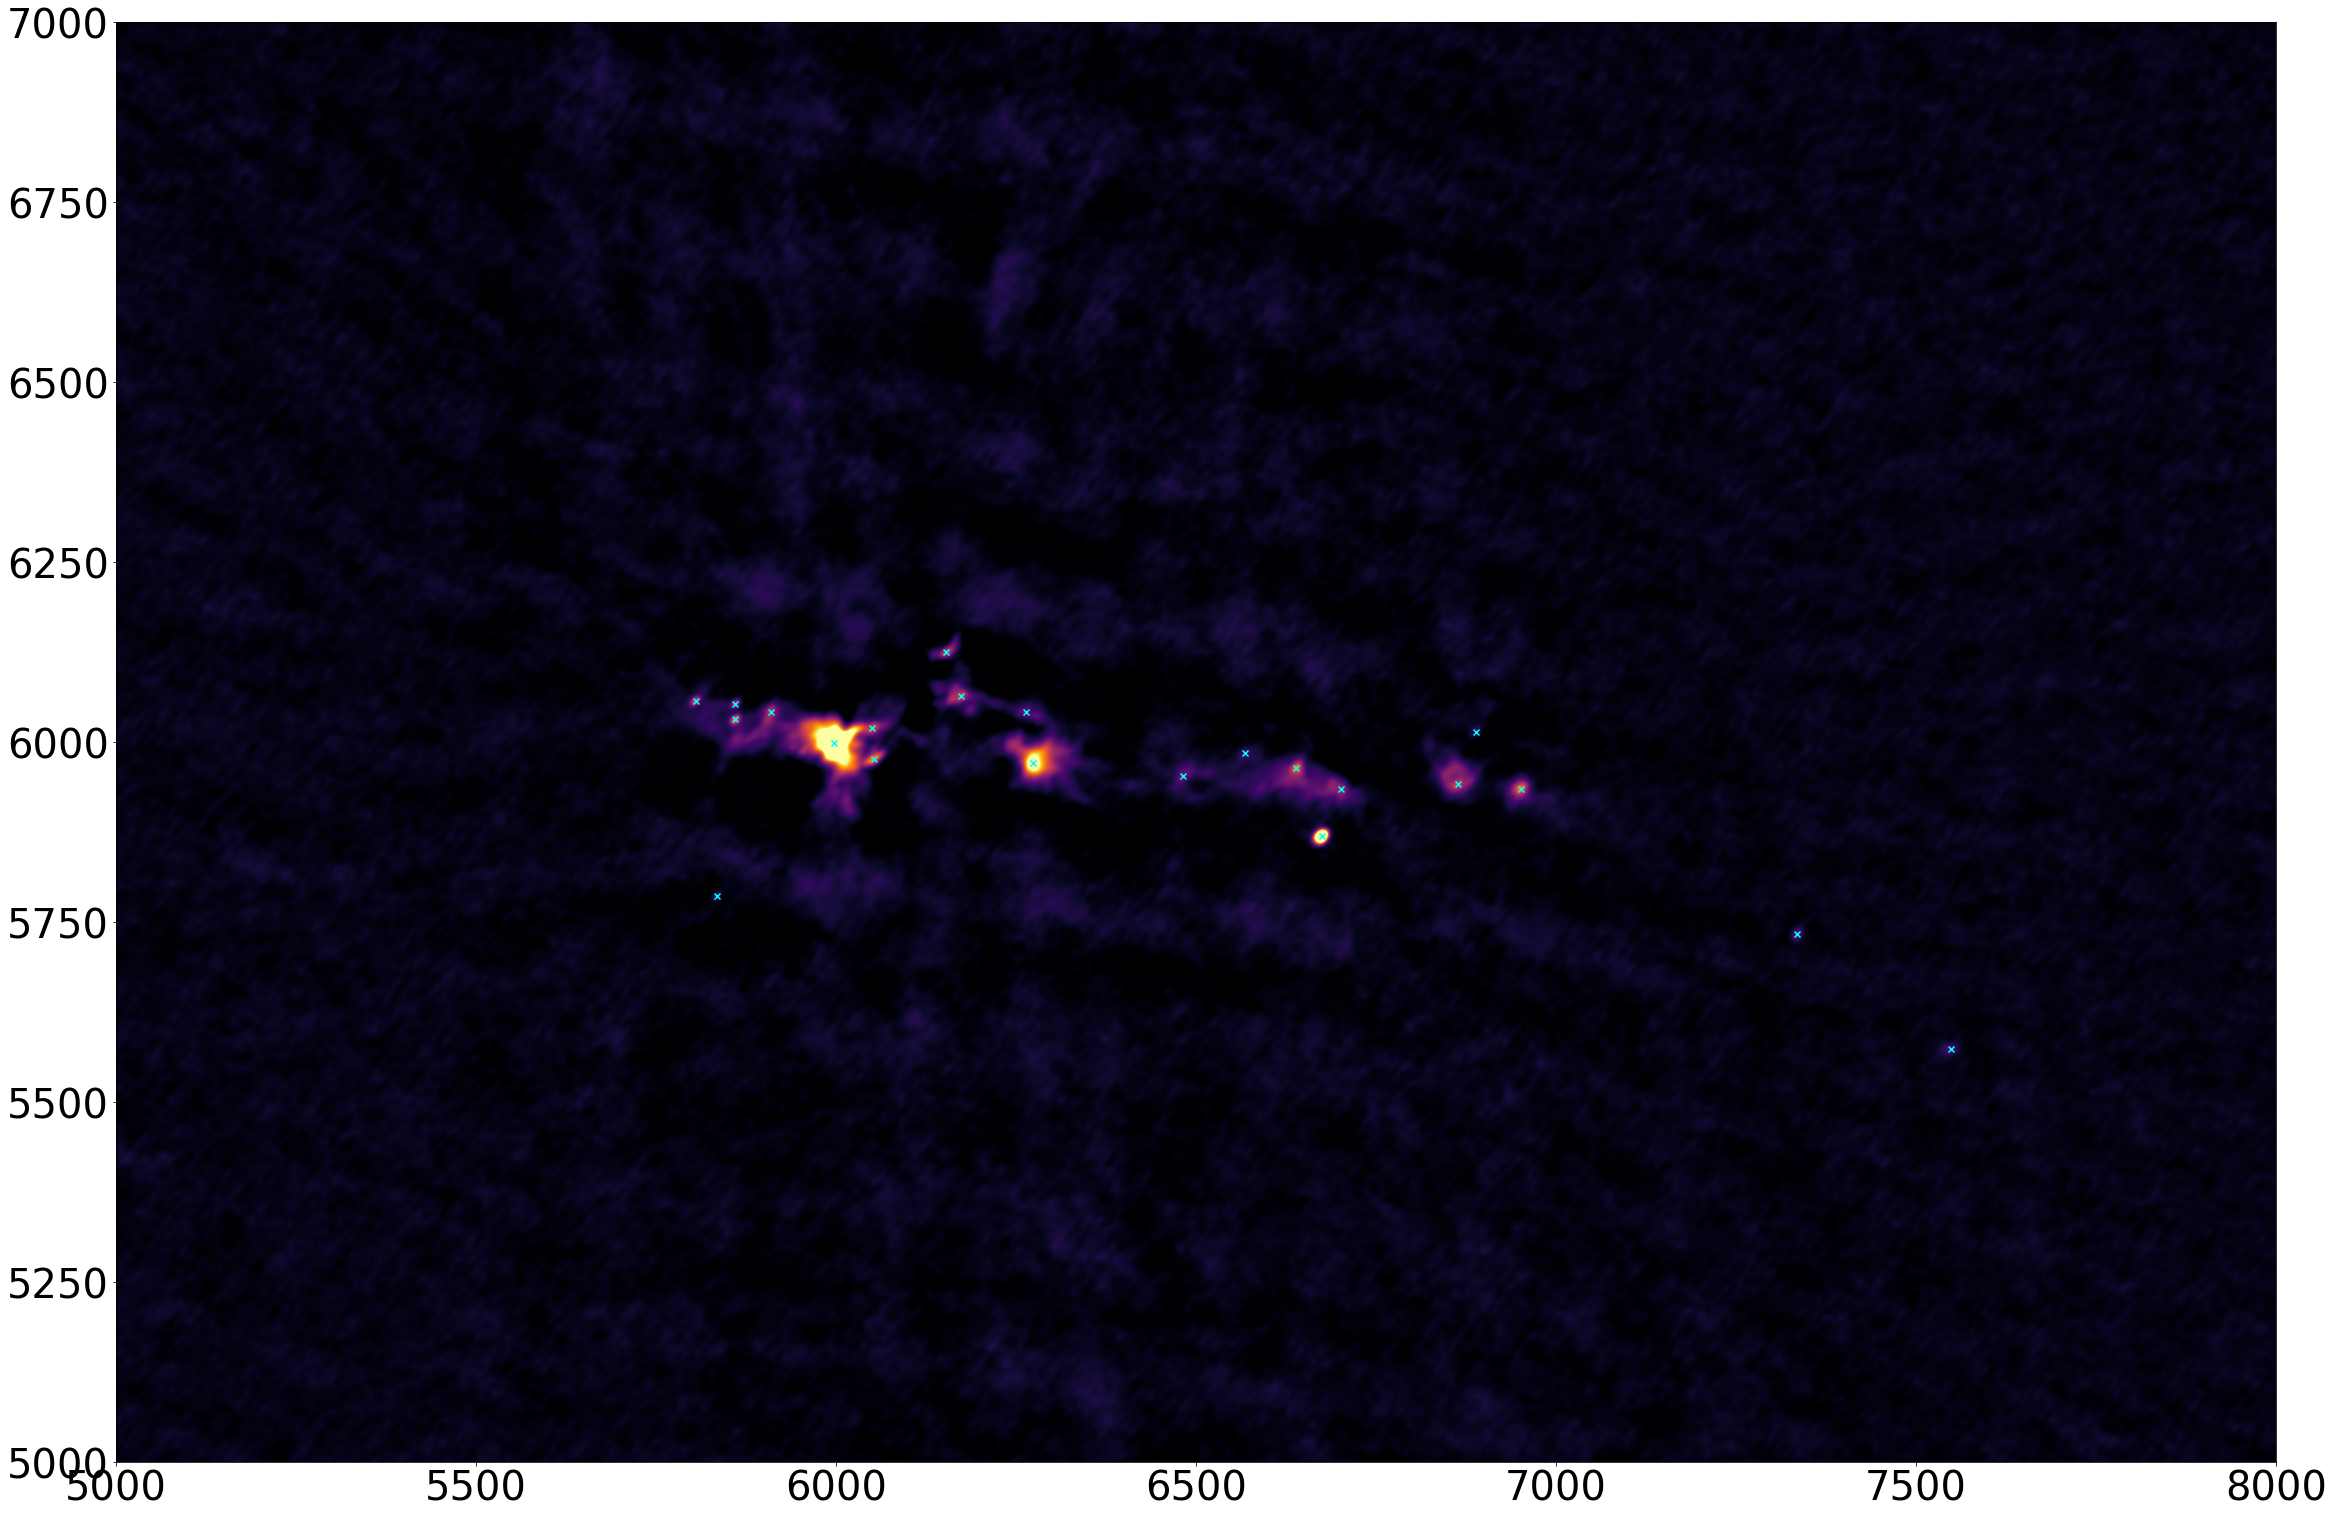

In [85]:
t = Table.read('dendro_table_w51n.fits')
x_b6 = t['peak_x_B6']
y_b6 = t['peak_y_B6']


fitsdata_b6 = fits.open(w51n_b6_conv)
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0,0,1,1])
imageb6 = fitsdata_b6[0].data

ax1.imshow(imageb6, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.0005704572860563252,vmax=0.015388233446712515)
ax1.scatter(x_b6,y_b6,marker='x',c='cyan')
ax1.set_xlim(5000,8000)
ax1.set_ylim(5000,7000)





In [98]:
def measure_alpha(b3data, b6data, table,  save=True, savedir=None):
    t = Table.read(table)
    peakx_b6 = t['peak_x_B6']
    peaky_b6 = t['peak_y_B6']
    peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T


    peakx_b3 = t['peak_x_B3']
    peaky_b3 = t['peak_y_B3']
    peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T

    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]

    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]

    scaleNB3_sr = (scaleNB3 * np.pi/180)**2
    scaleNB6_sr = (scaleNB6 * np.pi/180)**2


    num_source = len(peakxy_b6)
    

    B6flux = get_flux(imageb6,peakxy_b6, my_beamNB6,  wcsNB6, num_source,scaleNB6,savedir=savedir+'/B6/')
    B3flux = get_flux(imageb3,peakxy_b3, my_beamNB3,  wcsNB3, num_source,scaleNB3,savedir=savedir+'/B3/')
  
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])

    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    print(alpha)
    if save:
        t['alpha2'] = alpha
        t.write(table,format='fits',overwrite=True)

    
    return alpha

def get_flux(data,peakxy, beam1, wcsNB, num_source,pixel_scale, savedir=None):
    fluxarr = []
    cen_world = wcsNB.wcs_pix2world(peakxy,0)

    for i in range(num_source):
        x_cen = peakxy[i][0]
        y_cen = peakxy[i][1]
        cen = (x_cen, y_cen)
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa

        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        cutout = Cutout2D(data, positions, 4.0*major, wcs=wcsNB, mode='partial')
        frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
        aperture = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beam1.sr.value*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
    return np.array(fluxarr) 

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down



[ 2.3266203   1.5724385   0.27592242 -0.04498004  2.0066051   2.3262732
  0.90588456  1.9850229   0.99526787  3.8989344   1.7544961   2.0624218
  1.8568474   2.611094    1.5578319   2.275667    0.18087089  2.7222753
  1.7763416   1.1671637   1.5143281   1.804642  ]


(array([3., 0., 2., 2., 6., 4., 3., 1., 0., 1.]),
 array([-0.04498004,  0.3494114 ,  0.74380285,  1.1381943 ,  1.5325857 ,
         1.9269772 ,  2.3213687 ,  2.71576   ,  3.1101515 ,  3.5045428 ,
         3.8989344 ], dtype=float32),
 <BarContainer object of 10 artists>)

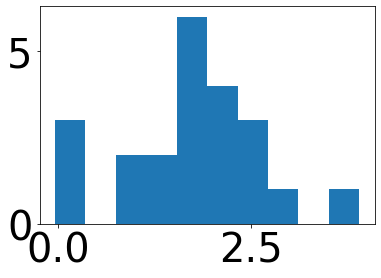

In [99]:

b3tob6ind=np.array([0,1,2,3,4,5,8,7,9,6,10,11,12,13,14,16,17,18,15,20,19,21])

alpha = measure_alpha(w51n_b3_tt0, w51n_b6_conv,'dendro_table_w51n.fits', savedir='./aper_w51n/')
plt.hist(alpha)

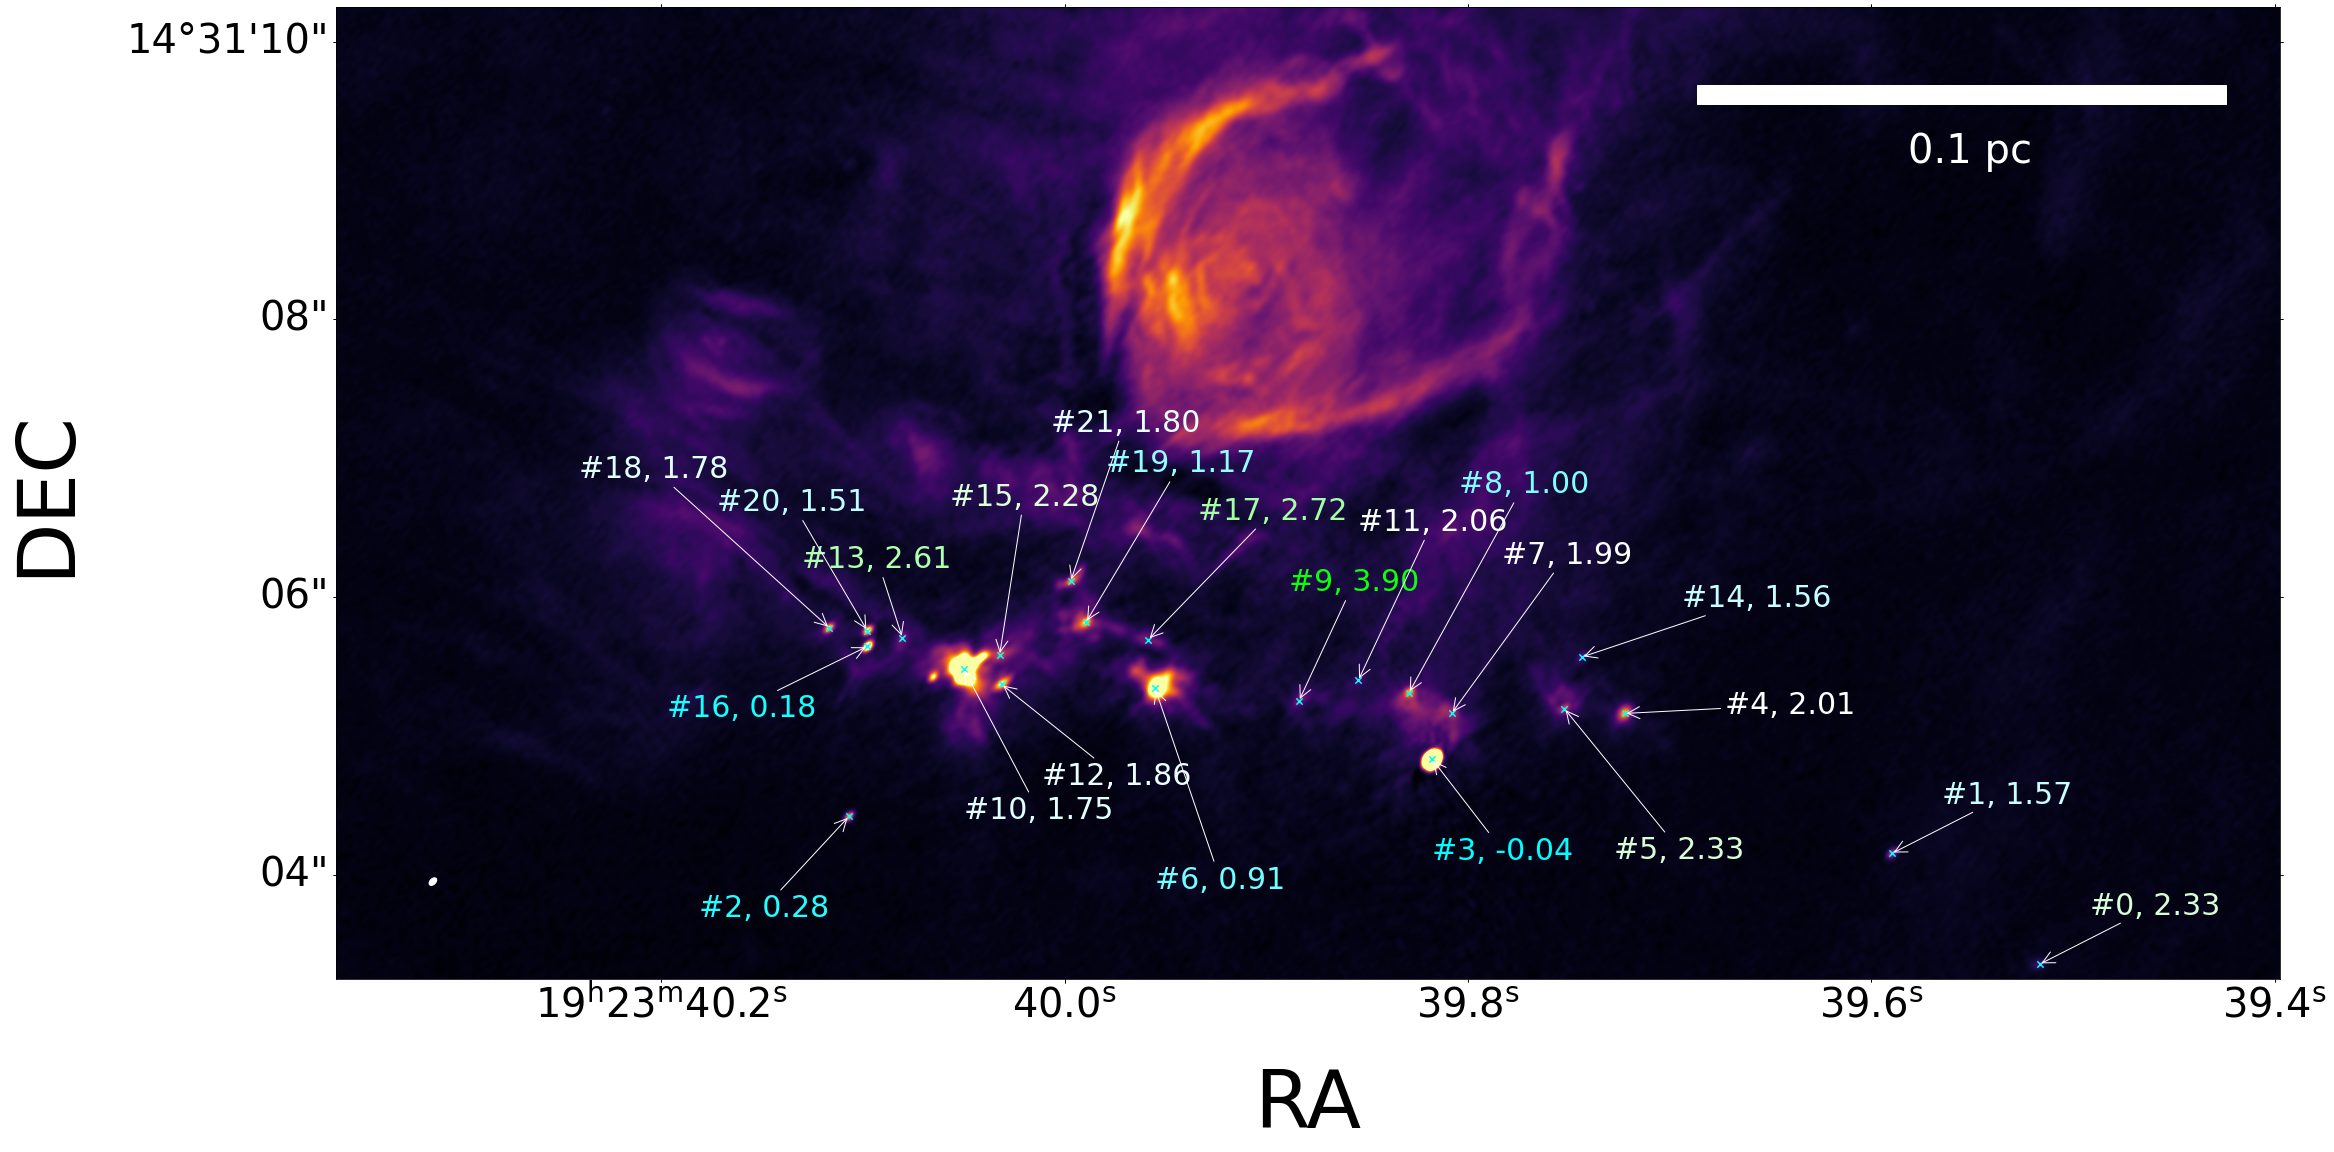

In [100]:
plt.rcParams['axes.labelsize']=80
plt.rcParams['xtick.labelsize']=40
plt.rcParams['ytick.labelsize']=40
plt.rcParams['axes.titlesize']=80
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.patches import Rectangle, Ellipse

def plot_peak(ax,image,tabledata,size=20,labelind=None,labeltext=None,xtextpos=None,ytextpos=None):
    cmap = cm.YlGn
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cyan',"w","lime"])
    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    
    table = Table.read(tabledata)
  
    xpos = table['peak_x_B3']
    ypos = table['peak_y_B3']
     
    
    ax.scatter(xpos,ypos, marker='x', c='cyan',s=size)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(len(labelind)):
        ax.annotate("#%d, %3.2f"%(i,labelind[i]),xy=(xpos[i],ypos[i]), xycoords='data', textcoords='offset pixels',
                    arrowprops=dict(arrowstyle="->",ec='w',fc='w'),xytext=(xtextpos[i],ytextpos[i]),fontsize=30,color=m.to_rgba(labelind[i]))
    
    
def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist, unit='pc',height=20,color='w',pad=40,size=40):
    phy_pix_scale = pixel_scale.value * np.pi/180 * dist
    ax.add_patch(Rectangle((xpos,ypos),scale/phy_pix_scale,height,color=color))
    ax.text(xpos+0.4*scale/phy_pix_scale, ypos+pad, '%2.1f %s'%(scale, unit), color=color,fontsize=size)
                
def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w'):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,180-angle.value,color=color))

xtextpos = [50, 50, -150,    0,  100,    50,    0,  50,   50,  -10,   0,     0,   40, -100, 100,  -50, -200,  50, -250, 20,  -150, -20]
ytextpos = [50, 50, -100, -100,    0,  -150, -200, 150,  200,  110,  -150, 150, -100, 70, 50, 150,  -70, 120,  150, 150, 120, 150]
    
fitsdata_b3 = fits.open(w51n_b3_tt0)
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.1,0.1,0.9,0.9],projection=wcsNB3)
imageb3 = fitsdata_b3[0].data[0][0]
ax1.imshow(imageb3, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.000055507826955594655,vmax=0.002191274995850258)
#mark_dendrogram_results(ax1, image, source_object,custom_dendro,
#                           vmin=-0.00044910456346381985,vfmax=0.006639306914117084)
#mark_dendrogram_results(ax1, imageb3_cut, source_object_b3,custom_dendro_b3
#                           ,vmin=-0.00044910456346381985,vmax=0.006639306914117084)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True,rejectreject=False)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True)


plot_peak(ax1,imageb3,'dendro_table_w51n.fits',size=40,labelind=alpha,xtextpos=xtextpos,ytextpos=ytextpos)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_xlim(6500,8500)
ax1.set_ylim(7000,8000)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
add_scale_bar(ax1, 7900,7900,0.1,scaleNB3,5.41e3,pad=-60)
add_beam(ax1,6600,7100,my_beamNB3, scaleNB3)
plt.savefig('dendroimage_w51n.png')

plt.show()
